In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

from stat570 import datasets

failure_stresses = datasets.failure_stresses.load_data()

In [2]:
with open('p2_data.tex', 'w') as f:
    f.write(failure_stresses.reset_index().to_latex(index=False))
failure_stresses

,0,1,2,3,4,5,6,7,8,9,10,11,12
Length (mm),,,,,,,,,,,,,
1,2.247,2.640,2.842,2.908,3.099,3.126,3.245,3.328,3.355,3.383,3.572,3.581,3.681
10,1.901,2.132,2.203,2.228,2.257,2.350,2.361,2.396,2.397,2.445,2.454,2.454,2.474
20,1.312,1.314,1.479,1.552,1.700,1.803,1.861,1.865,1.944,1.958,1.966,1.997,2.006
50,1.339,1.434,1.549,1.574,1.589,1.613,1.746,1.753,1.764,1.807,1.812,1.840,1.852


In [3]:
from scipy import linalg
from scipy import optimize

def fit_exponential_model(y):
    lambda_hat = 1/np.mean(y)
    return lambda_hat, np.square(lambda_hat)/len(y)

def fit_quasi_likelihood_model(y):
    lambda_hat, lambda_hat_variance = fit_exponential_model(y)    
    alpha_hat = np.square(lambda_hat)*np.sum(np.square(y - 1/lambda_hat))/(len(y) - 1)    
    return lambda_hat, lambda_hat_variance*alpha_hat, alpha_hat

def fit_sandwich_model(y):
    lambda_hat, _ = fit_exponential_model(y)
    return lambda_hat, np.power(lambda_hat, 4)*np.mean(np.square(y - 1/lambda_hat))/len(y)

def fit_weibull_model(y):
    def score(params):
        eta = params[0]
        alpha = params[1]
        n = len(y)
        fixed = n*np.array([
            1/eta - np.log(alpha),
            -eta/alpha,
        ])
        summed = np.sum(np.array([
            np.log(y)-(np.log(y) - np.log(alpha))*np.power(y/alpha, eta),
            (eta/alpha)*np.power(y/alpha, eta)
        ]).transpose((1,0)), axis=0)
        
        return fixed + summed    
    params = optimize.root(score, np.array([11,2]))['x']
    
    def fisher_information(params):
        eta = params[0]
        alpha = params[1]
        
        return np.sum(np.array([
            [
                1/np.square(eta) + np.square(np.log(y) - np.log(alpha))*np.power(y/alpha, eta),
                1/alpha - 1/alpha*np.power(y/alpha, eta) - eta/alpha*(np.log(y) - np.log(alpha))*np.power(y/alpha, eta)
            ],
            [
                1/alpha - 1/alpha*np.power(y/alpha, eta) - eta/alpha*(np.log(y) - np.log(alpha))*np.power(y/alpha, eta),
                -eta/(alpha*alpha) + eta/(alpha*alpha)*np.power(y/alpha, eta) + np.square(eta/alpha)*np.power(y/alpha, eta)
            ],
        ]).transpose((2,1,0)), axis=0)
    
    param_variances = linalg.cho_solve(
        linalg.cho_factor(fisher_information(params)), np.eye(len(params)))
    
    return params, param_variances

## Exponential Model

In [4]:
def exponential_model_as_dict(fit, y):
    lambda_hat, lambda_hat_variance = fit(y)
    return {
        '$\\hat{\\lambda}$': lambda_hat,
        'Standard error': np.sqrt(lambda_hat_variance),
    }

failure_stresses_exponential_estimates = failure_stresses.apply(
    lambda y: exponential_model_as_dict(fit_exponential_model, y), axis=1, result_type='expand')

with open('p2_exponential_estimates.tex', 'w') as f:
    f.write(failure_stresses_exponential_estimates.reset_index().to_latex(
        index=False, escape=False))
    
failure_stresses_exponential_estimates

,$\hat{\lambda}$,Standard error
Length (mm),,
1,0.317019,0.087925
10,0.432584,0.119977
20,0.571253,0.158437
50,0.599852,0.166369


## Quasi-likelihood Model

In [5]:
from collections import OrderedDict

def quasi_likelihood_model_as_dict(fit, y):
    lambda_hat, lambda_hat_variance, alpha_hat = fit(y)
    return OrderedDict([
        ('$\\hat{\\lambda}$', lambda_hat),
        ('$\\hat{\\alpha}$', alpha_hat),
        ('Standard error ($\\hat{\\lambda}$)', np.sqrt(lambda_hat_variance)),
    ])

failure_stresses_quasi_likelihood_estimates = failure_stresses.apply(
    lambda y: quasi_likelihood_model_as_dict(fit_quasi_likelihood_model, y), axis=1, result_type='expand')
failure_stresses_quasi_likelihood_estimates = failure_stresses_quasi_likelihood_estimates[
    failure_stresses_quasi_likelihood_estimates.columns[[1,0,2]]]

with open('p2_quasi_likelihood_estimates.tex', 'w') as f:
    f.write(failure_stresses_quasi_likelihood_estimates.reset_index().to_latex(
        index=False, escape=False))

failure_stresses_quasi_likelihood_estimates

,$\hat{\lambda}$,$\hat{\alpha}$,Standard error ($\hat{\lambda}$)
Length (mm),,,
1,0.317019,0.016873,0.011421
10,0.432584,0.005078,0.008550
20,0.571253,0.021199,0.023068
50,0.599852,0.009633,0.016329


## Sandwich Estimation

In [6]:
failure_stresses_sandwich_estimates = failure_stresses.apply(
    lambda y: exponential_model_as_dict(fit_sandwich_model, y), axis=1, result_type='expand')

with open('p2_sandwich_estimates.tex', 'w') as f:
    f.write(failure_stresses_sandwich_estimates.reset_index().to_latex(
        index=False, escape=False))

failure_stresses_sandwich_estimates

,$\hat{\lambda}$,Standard error
Length (mm),,
1,0.317019,0.010973
10,0.432584,0.008215
20,0.571253,0.022163
50,0.599852,0.015688


## Weibull Model

In [7]:
def weibull_model_as_dict(fit, y):
    (eta_hat, alpha_hat), param_variances = fit(y)
    return {
        '$\\hat{\\eta}$': eta_hat,
        'Standard error ($\\hat{\\eta}$)': np.sqrt(param_variances[0,0]),
        '$\\hat{\\alpha}$': alpha_hat,
        'Standard error ($\\hat{\\alpha}$)': np.sqrt(param_variances[1,1]),
    }

failure_stresses_weibull_estimates = failure_stresses.apply(
    lambda y: weibull_model_as_dict(fit_weibull_model, y), axis=1, result_type='expand')
failure_stresses_weibull_estimates = failure_stresses_weibull_estimates[
    failure_stresses_weibull_estimates.columns[[1,3,0,2]]]

with open('p2_weibull_estimates.tex', 'w') as f:
    f.write(failure_stresses_weibull_estimates.reset_index().to_latex(
        index=False, escape=False))
    
failure_stresses_weibull_estimates

,$\hat{\eta}$,Standard error ($\hat{\eta}$),$\hat{\alpha}$,Standard error ($\hat{\alpha}$)
Length (mm),,,,
1,10.334057,2.349637,3.318984,0.093442
10,21.345249,5.054394,2.377346,0.032231
20,9.635766,2.311027,1.852108,0.055750
50,13.828569,3.212535,1.735277,0.036532


In [8]:
def plot_estimate_quantiles(axes, plot_fn, estimates):
    for i, (length, estimate) in enumerate(estimates.iterrows()):
        ax = axes[i//2][i % 2]
        plot_fn(ax, length, estimate)       
        ax.set_title('Length = {}mm'.format(length))
        ax.grid(True)
        ax.set_aspect('equal', adjustable='datalim')    
        min_datalim = np.min([ax.get_xlim(), ax.get_ylim()])
        max_datalim = np.max([ax.get_xlim(), ax.get_ylim()])
        ax.plot([min_datalim, max_datalim], [min_datalim, max_datalim], '--k')        

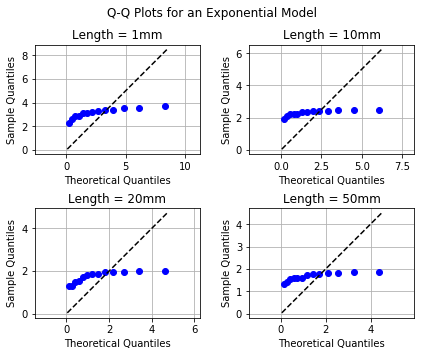

In [9]:
fig, axes = plt.subplots(figsize=(6,5), ncols=2, nrows=2)

def plot_exponential_model_quantiles(ax, length, estimate):
    lambda_hat = estimate[0]
    sm.qqplot(failure_stresses.loc[length], dist=stats.expon, loc=0, scale=1/lambda_hat, ax=ax)
    
plot_estimate_quantiles(axes, plot_exponential_model_quantiles, failure_stresses_exponential_estimates)

fig.suptitle('Q-Q Plots for an Exponential Model')
fig.tight_layout()
fig.subplots_adjust(top=0.875)
fig.savefig('p2_qq_exponential.pdf', bbox_inches='tight')

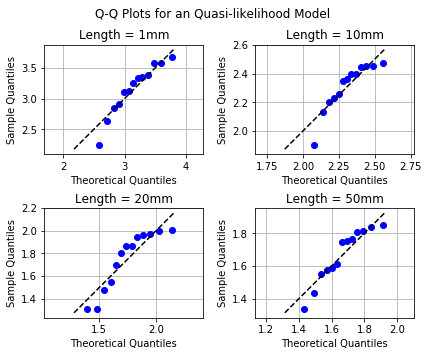

In [10]:
fig, axes = plt.subplots(figsize=(6,5), ncols=2, nrows=2)

def plot_quasi_likelihood_quantiles(ax, length, estimate):
    lambda_hat = estimate[0]
    alpha_hat = estimate[1]
    sm.qqplot(failure_stresses.loc[length], dist=stats.gamma,
              distargs=(1/alpha_hat,),
              loc=0, scale=alpha_hat/lambda_hat, ax=ax)

plot_estimate_quantiles(axes, plot_quasi_likelihood_quantiles,
                        failure_stresses_quasi_likelihood_estimates)

fig.suptitle('Q-Q Plots for an Quasi-likelihood Model')
fig.tight_layout()
fig.subplots_adjust(top=0.875)
fig.savefig('p2_qq_quasi_likelihood.pdf', bbox_inches='tight')

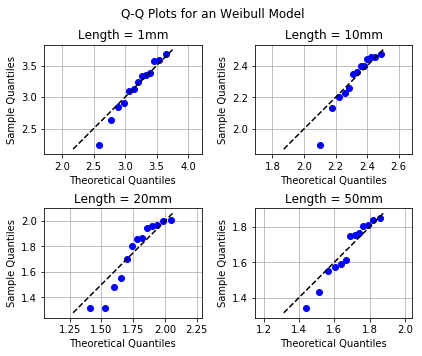

In [11]:
fig, axes = plt.subplots(figsize=(6,5), ncols=2, nrows=2)

def plot_weibull_quantiles(ax, length, estimate):
    eta_hat = estimate[0]
    alpha_hat = estimate[2]
    sm.qqplot(failure_stresses.loc[length], dist=stats.weibull_min,
              distargs=(eta_hat,),
              loc=0, scale=alpha_hat, ax=ax)

plot_estimate_quantiles(axes, plot_weibull_quantiles,
                        failure_stresses_weibull_estimates)

fig.suptitle('Q-Q Plots for an Weibull Model')
fig.tight_layout()
fig.subplots_adjust(top=0.875)
fig.savefig('p2_qq_weibull.pdf', bbox_inches='tight')